In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import statistics
%matplotlib inline

df = pd.read_csv('curve_data.csv')
df.head()

,Term,Rank,Log,Search Volume,Search Volume Trend (30 days),Competing Products,Sponsored ASINs
0,were good,686707,0.349315,894,0.0,100000,94
1,top 100,347635,0.644963,1708,0.0,100000,8
2,good for u,370630,0.617146,1710,0.0,100000,0
3,cheap masks for women,718434,0.329699,512,0.0,100000,0
4,super deep,249292,0.789378,2300,0.0,90000,491


In [2]:
df = df.dropna(how='any')

In [4]:
df=df[['Rank', 'Search Volume']]

X = df['Rank'].values
y = df['Search Volume'].values

order = np.argsort(X)
X = X[order]
y = y[order]

In [5]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

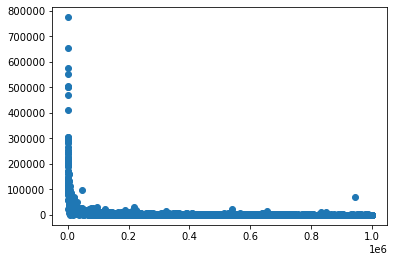

In [5]:
plt.scatter(X, y)

We can take the logs to get a better set of data points to fit a line to.

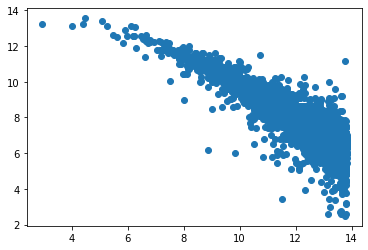

In [6]:
plt.scatter(np.log(X), np.log(y))

In [7]:
from sklearn.linear_model import LinearRegression

lX=np.log(X).reshape(-1,1)
ly=np.log(y).reshape(-1,1)

y_pred_log= LinearRegression()
y_pred_log.fit(lX,ly)

LinearRegression()

In [8]:
print(y_pred_log.coef_)
print(y_pred_log.intercept_)

[[-0.89446276]]
[18.79645153]


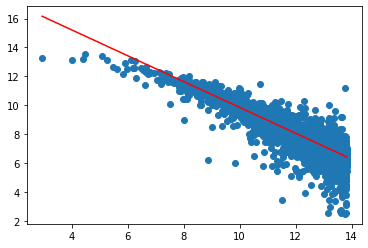

In [9]:
plt.scatter(np.log(X), np.log(y))
plt.plot(np.log(X), np.log(X)*-0.89446276+18.79645153, color='red')

In [10]:
print(" Intercept value of Model is: " ,y_pred_log.intercept_)
print("Co-efficient Value of Log Model is: ", y_pred_log.coef_)

print("Equation is: np.exp(",y_pred_log.intercept_[0],")*pow(X,",y_pred_log.coef_[0][0],")")

 Intercept value of Model is:  [18.79645153]
Co-efficient Value of Log Model is:  [[-0.89446276]]
Equation is: np.exp( 18.796451534809837 )*pow(X, -0.8944627602067986 )


In [11]:
def predicts(X):
    l = []
    for i in X:
        p = np.exp(18.796451534809837)*pow(X, -0.8944627602067986)
        l.append(p)
    return l

pf_preds = predicts(X)

In [12]:
pf_preds[0].shape

(37604,)

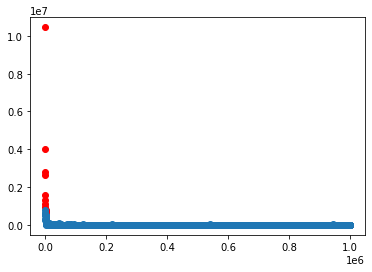

In [13]:
plt.scatter(X,pf_preds[0], color='red')
plt.scatter(X,y)

In [14]:
from sklearn.metrics import r2_score

r2_score(y, pf_preds[0])

-17.691177825697405

Woah, we have some room for improvement here.

In [15]:
l_model= y_pred_log.predict(lX)
l_model

array([[16.16276052],
       [15.21204123],
       [14.84396317],
       ...,
       [ 6.43903029],
       [ 6.43900882],
       [ 6.43900614]])

In [16]:
pmsh_pf_1 = pd.DataFrame({'Actual':np.log(y).flatten(), 'Predict': l_model.flatten()})
pmsh_pf_1

,Actual,Predict
0,13.260827,16.162761
1,13.129536,15.212041
2,13.222605,14.843963
3,13.560261,14.791640
4,13.388360,14.262505
...,...,...
37599,7.026427,6.439122
37600,6.450470,6.439108
37601,6.504288,6.439030
37602,6.354370,6.439009


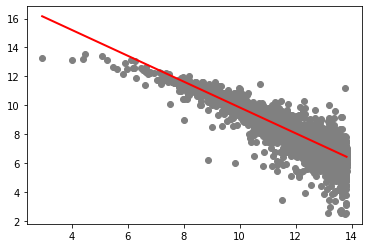

In [17]:
plt.scatter(lX, ly,  color='gray')
plt.plot(lX, l_model, color='red', linewidth=2)
plt.show()

In [18]:
lX = np.asarray([item for x in lX for item in x])
ly = np.asarray([item for i in ly for item in i])

print(X.shape)
print(y.shape)
print(lX.shape)
print(ly.shape)

(37604,)
(37604,)
(37604,)
(37604,)


let's try to fit the curve using np.poly1d

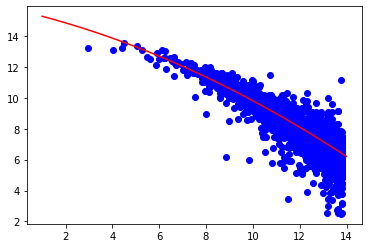

In [19]:
model = np.poly1d(np.polyfit(lX, ly, 2))
polyline = np.linspace(1, 14, 500)

plt.plot(polyline, model(polyline), '-', color='red')
plt.scatter(lX, ly, color='blue')

ok, it already looks a bit better and should take the edge off the overshoot on the far left. Let's output the equation.

In [21]:
print(model)
print("y = (",model[2],"*x**2)+(",model[1],"*x)+",model[0])

          2
-0.02262 x - 0.3591 x + 15.67
y = ( -0.022618850909857352 *x**2)+( -0.35907814063444193 *x)+ 15.67103158881088


In [22]:
#y = ax2 + bx + c
def tester(X):
    ty=[]
    for x in X:
        y = (-0.02261885*x**2)+(-0.35907814*x)+15.67103159
        ty.append(y)
    return ty

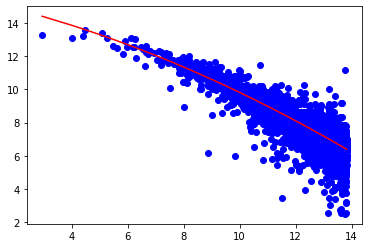

In [23]:
tester_y = tester(lX)
plt.plot(lX, tester_y, '-', color='red')
plt.scatter(lX, ly, color='blue')

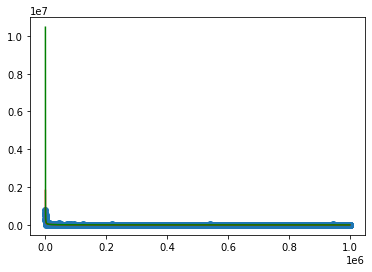

In [24]:
import math

def predicter(X):
    ty=[]
    for x in X:
        lx = np.log(x)
        y = (-0.02261885*lx**2)+(-0.35907814*lx)+15.67103159
        y = math.e**y
        ty.append(y)
    return ty

preds = predicter(X)

plt.scatter(X, y)
plt.plot(X, preds, color='red')
plt.plot(X, pf_preds[0], color='green')

We're still overshooting by a lot. Let's see if we can improve it more.

In [25]:
test_n = 19

print(np.exp(18.796451534809837)*pow(test_n, -0.8944627602067986))
print(predicter([test_n]))

10456773.604881031
[1826019.102352234]


In [26]:
r2_score(y, preds)

0.6336124317481571

We'll try another method to try to improve this. We'll use scipy's curve_fit function for this, and we'll try it with multiple equations to see which gives us the best fit.

In [27]:
from scipy.optimize import curve_fit

In [28]:
def func1(x, a, b, c):
    return a*x**2+b*x+c

def func2(x, a, b, c):
    return a*x**3+b*x+c

def func3(x, a, b, c):
    return a*x**3+b*x**2+c

def func4(x, a, b, c):
    return a*np.exp(b*x)+c 

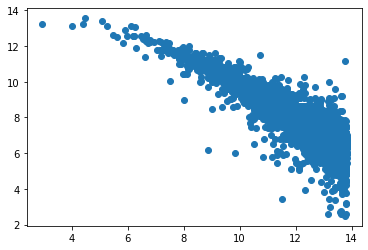

In [29]:
x = np.log(X)
y = np.log(y)
plt.scatter(x,y)

In [30]:
params, _ = curve_fit(func1, x, y)
a, b, c = params[0], params[1], params[2]
yfit1 = a*x**2+b*x+c

params, _  = curve_fit(func2, x, y)
a, b, c = params[0], params[1], params[2]
yfit2 = a*x**3+b*x+c

params, _  = curve_fit(func3, x, y)
a, b, c = params[0], params[1], params[2]
yfit3 = a*x**3+b*x**2+c

params, _  = curve_fit(func4, x, y)
a, b, c = params[0], params[1], params[2]
yfit4 = a*np.exp(x*b)+c

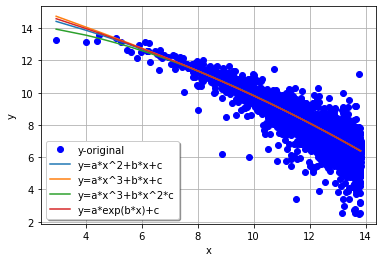

In [33]:
plt.plot(x, y, 'bo', label="y-original")
plt.plot(x, yfit1, label="y=a*x^2+b*x+c")
plt.plot(x, yfit2, label="y=a*x^3+b*x+c")
plt.plot(x, yfit3, label="y=a*x^3+b*x^2*c")
plt.plot(x, yfit4, label="y=a*exp(b*x)+c")
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best', fancybox=True, shadow=True)
plt.grid(True)
plt.show() 

let's take the best equation for the fit, func3.

In [34]:
params, _  = curve_fit(func3, x, y)
a, b, c = params[0], params[1], params[2]
print("yfit3 = ",a,"*x**3+",b,"*x**2+",c)

yfit3 =  0.000982760553677512 *x**3+ -0.05546049083263377 *x**2+ 14.391678884278814


In [36]:
math.e

2.718281828459045

math.e is Euler's number and can be used to reverse the logs in the equations.

In [35]:
def final_predicter(X):
    ty=[]
    for x in X:
        lx = np.log(x)
        y = 0.000982760553677512 *lx**3+ -0.05546049083263377 *lx**2+ 14.391678884278814
        y = math.e**y
        ty.append(y)
    return ty

In [36]:
df=df[['Rank', 'Search Volume']]

X = df['Rank'].values
y = df['Search Volume'].values

order = np.argsort(X)
X = X[order]
y = y[order]

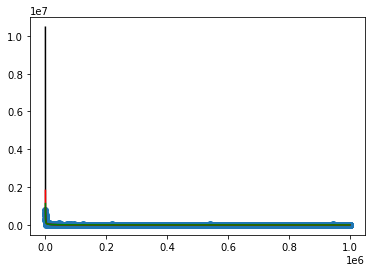

In [37]:
import math

final_preds = final_predicter(X)

plt.scatter(X, y)
plt.plot(X, pf_preds[0], color='black')
plt.plot(X, preds, color='red')
plt.plot(X, final_preds, color='green')

We can see how our equation improved massively (green line is our most recent and doesn't overshoot nearly as much on the left as the previous two lines [red and black])

In [38]:
from sklearn import metrics

metrics.explained_variance_score(y, final_preds)

0.8666747311884967

(-20000.0, 20000.0)

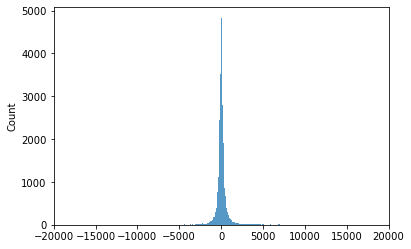

In [39]:
sns.histplot(y-final_preds, bins=10000)
plt.xlim(-20000,20000)

We can see our errors have a normal distribution, meaning the model can be trusted.

In [40]:
r2_score(y, final_preds)

0.8665130298624291

We also have a much better score than we originally had.